
# Text-to-Image Retrieval con CLIP en Caltech-256


# Taller 3

In [1]:
%pip install -q torch torchvision ftfy regex tqdm pillow numpy
%pip install -q git+https://github.com/openai/CLIP.git
%pip install -q faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 83.4 MB/s eta 0:00:00


In [2]:

import os, sys, random, tarfile, shutil, math, json, urllib.request
from pathlib import Path
from typing import List, Tuple, Dict

import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn.functional as F
import torchvision.transforms as T

import clip

# FAISS opcional
try:
    import faiss  # type: ignore
    HAS_FAISS = True
except Exception:
    HAS_FAISS = False

import matplotlib.pyplot as plt

def set_seed(seed: int = 123):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

print("PyTorch:", torch.__version__, "| CUDA:", torch.cuda.is_available(), "| FAISS:", 'yes' if HAS_FAISS else 'no')

PyTorch: 2.8.0+cu126 | CUDA: True | FAISS: yes


In [3]:
# --- Configuración ---
DATA_ROOT = Path("data")
DATASET_URL = "https://data.caltech.edu/records/nyy15-4j048/files/256_ObjectCategories.tar?download=1"
TAR_NAME = "256_ObjectCategories.tar"

# Fracción de muestreo por clase (requisito 20%–50%)
SAMPLE_FRAC = 0.30
MODEL_NAME = "ViT-B/32"
BATCH_SIZE = 64
TOPK = 10
SEED = 42

assert 0.20 <= SAMPLE_FRAC <= 0.50, "SAMPLE_FRAC debe estar entre 0.20 y 0.50"
set_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
model, clip_preprocess = clip.load(MODEL_NAME, device=device, jit=False)
model.eval()
device

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 305MiB/s]


'cuda'

In [4]:
# --- Descarga y extracción del dataset ---
DATA_ROOT.mkdir(parents=True, exist_ok=True)
tar_path = DATA_ROOT / TAR_NAME
target_dir = DATA_ROOT / "256_ObjectCategories"

if target_dir.exists() and any(target_dir.iterdir()):
    print("El dataset ya parece estar extraído en:", target_dir)
else:
    if not tar_path.exists():
        print("Descargando dataset...")
        urllib.request.urlretrieve(DATASET_URL, tar_path)
        print("Descarga completada:", tar_path)
    else:
        print("Archivo tar ya existe:", tar_path)

    print("Extrayendo... (puede tardar varios minutos)")
    with tarfile.open(tar_path, "r") as tar:
        tar.extractall(path=DATA_ROOT)
    print("Extracción completada en:", target_dir)

# Contando imágenes
num_imgs = sum(1 for _ in target_dir.rglob("*.jpg"))
print("Total de imágenes encontradas:", num_imgs)

Descargando dataset...
Descarga completada: data/256_ObjectCategories.tar
Extrayendo... (puede tardar varios minutos)


/tmp/ipython-input-3529259939.py:18: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=DATA_ROOT)


Extracción completada en: data/256_ObjectCategories
Total de imágenes encontradas: 30607


In [5]:
def discover_images(data_root: Path) -> List[Tuple[str, str]]:
    '''
    Recorre data_root/256_ObjectCategories/<id>.<class>/*.jpg
    Retorna lista de (ruta_img, nombre_clase).
    '''
    data_dir = data_root / "256_ObjectCategories"
    assert data_dir.exists(), f"No se encontró {data_dir}"
    pairs = []
    for class_dir in sorted(data_dir.iterdir()):
        if class_dir.is_dir():
            class_name = class_dir.name.split(".", 1)[-1]  # "<id>.<class>" -> "class"
            for img_path in class_dir.glob("*.jpg"):
                pairs.append((str(img_path), class_name))
    return pairs

def sample_subset(pairs: List[Tuple[str, str]], frac: float) -> List[Tuple[str, str]]:
    '''
    Muestreo estratificado por clase con fracción 'frac'.
    '''
    assert 0.0 < frac <= 1.0
    by_class: Dict[str, List[str]] = {}
    for p, c in pairs:
        by_class.setdefault(c, []).append(p)
    sampled = []
    for c, paths in by_class.items():
        k = max(1, int(len(paths) * frac))
        chosen = random.sample(paths, k)
        sampled.extend((p, c) for p in chosen)
    return sampled

all_pairs = discover_images(DATA_ROOT)
pairs = sample_subset(all_pairs, SAMPLE_FRAC)
print(f"Total imágenes (todas): {len(all_pairs)} | Muestra ({SAMPLE_FRAC*100:.0f}%): {len(pairs)}")

classes = sorted(list({c for _, c in pairs}))
class_to_idx = {c: i for i, c in enumerate(classes)}
len(classes), classes[:10]

Total imágenes (todas): 30607 | Muestra (30%): 9076


(257,
 ['airplanes-101',
  'ak47',
  'american-flag',
  'backpack',
  'baseball-bat',
  'baseball-glove',
  'basketball-hoop',
  'bat',
  'bathtub',
  'bear'])

# Embeddings

In [6]:
def build_transforms(image_size: int = 224):
    # Transform de CLIP ViT-B/32 (resize+center crop+normalize)
    return T.Compose([
        T.Resize(image_size, interpolation=T.InterpolationMode.BICUBIC),
        T.CenterCrop(image_size),
        T.ToTensor(),
        T.Normalize(mean=(0.48145466, 0.4578275, 0.40821073),
                    std=(0.26862954, 0.26130258, 0.27577711)),
    ])

@torch.no_grad()
def embed_images(model, preprocess, device, items: List[Tuple[str, str]], batch_size: int = 64):
    '''
    items: lista de (ruta_img, class_name)
    Retorna:
      img_embs: (N, D) tensor L2-normalizado
      meta: dict con keys 'paths', 'classes'
    '''
    paths = [p for p, _ in items]
    classes_list = [c for _, c in items]

    all_embs = []
    ok_paths, ok_classes = [], []
    for i in tqdm(range(0, len(paths), batch_size), desc="Embeddings imágenes"):
        batch_paths = paths[i:i+batch_size]
        imgs = []
        keep_idx = []
        for j, p in enumerate(batch_paths):
            try:
                im = Image.open(p).convert("RGB")
                imgs.append(preprocess(im))
                keep_idx.append(j)
            except Exception:
                pass
        if not imgs:
            continue
        img_tensor = torch.stack(imgs).to(device)
        embs = model.encode_image(img_tensor)
        embs = F.normalize(embs, dim=-1)
        all_embs.append(embs.cpu())
        # acumula meta consistentes con imágenes válidas
        for j in keep_idx:
            ok_paths.append(batch_paths[j])
            ok_classes.append(classes_list[i + j])

    if not all_embs:
        raise RuntimeError("No se pudieron embedir imágenes (¿dataset vacío o corrupto?).")
    img_embs = torch.cat(all_embs, dim=0)
    return img_embs, {"paths": ok_paths, "classes": ok_classes}

preprocess = build_transforms(224)
img_embs_t, meta = embed_images(model, preprocess, device, pairs, batch_size=BATCH_SIZE)
img_embs = img_embs_t.numpy().astype(np.float32)  # (N, D)
N, D = img_embs.shape
N, D

Embeddings imágenes: 100%|██████████| 142/142 [00:44<00:00,  3.19it/s]


(9076, 512)

In [7]:

class CosineSearcher:
    '''
    Búsqueda por similitud coseno. Usa FAISS si está disponible.
    '''
    def __init__(self, embs: np.ndarray, use_faiss: bool = True):
        self.dim = embs.shape[1]
        self.use_faiss = use_faiss and HAS_FAISS
        if self.use_faiss:
            self.index = faiss.IndexFlatIP(self.dim)  # IP sobre vectores normalizados ≡ coseno
            self.index.add(embs.astype(np.float32))
        else:
            self.embs = embs  # (N, D)

    def search(self, queries: np.ndarray, topk: int = 10):
        if self.use_faiss:
            sims, idx = self.index.search(queries.astype(np.float32), topk)
            return sims, idx
        else:
            sims = queries @ self.embs.T  # (Q, N)
            idx = np.argsort(-sims, axis=1)[:, :topk]
            top_sims = np.take_along_axis(sims, idx, axis=1)
            return top_sims, idx

searcher = CosineSearcher(img_embs, use_faiss=True)
print(f"Índice: {'FAISS' if searcher.use_faiss else 'matricial'} | N={img_embs.shape[0]} D={img_embs.shape[1]}")

Índice: FAISS | N=9076 D=512


In [8]:

def build_class_prompts(classes: List[str]) -> List[str]:
    return [f"a photo of a {c.replace('_', ' ')}" for c in classes]

@torch.no_grad()
def embed_texts(model, tokenizer, device, texts: List[str]):
    tokens = tokenizer(texts, truncate=True).to(device)
    text_embs = model.encode_text(tokens)
    text_embs = F.normalize(text_embs, dim=-1)
    return text_embs.cpu()

# Prompts por clase
prompts = build_class_prompts(classes)
text_embs_t = embed_texts(model, clip.tokenize, device, prompts)
text_embs = text_embs_t.numpy().astype(np.float32)  # (C, D)

# Ground-truth por clase
class_to_idx = {c: i for i, c in enumerate(classes)}
class_of_image = np.array([class_to_idx[c] for c in meta["classes"]], dtype=np.int32)
gt_sets = []
for cls_idx in range(len(classes)):
    relevant = set(np.where(class_of_image == cls_idx)[0].tolist())
    gt_sets.append(relevant)

# Búsqueda para todas las clases
sims, idx = searcher.search(text_embs, topk=TOPK)

def recall_at_k(gt_sets: List[set], retrieved_idx, k: int) -> float:
    Q = len(gt_sets)
    hits = 0
    for q in range(Q):
        topk = set(retrieved_idx[q, :k].tolist())
        if len(gt_sets[q].intersection(topk)) > 0:
            hits += 1
    return hits / max(1, Q)

for K in [1, 5, 10]:
    if K > TOPK:
        continue
    r_at_k = recall_at_k(gt_sets, idx, k=K)
    print(f"Recall@{K}: {r_at_k:.3f}")


Recall@1: 0.946
Recall@5: 0.984
Recall@10: 0.992


# Search

In [15]:
import os, math, time, textwrap, itertools
from typing import List, Optional, Tuple
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import torch

# =========================
# Helpers de visualización
# =========================
def _truncate(s: str, n=60):
    s = str(s)
    return s if len(s) <= n else s[:n-1] + "…"

def _make_square_thumb(path: str, size: int = 256) -> Image.Image:
    """Abre imagen a RGB y hace thumbnail cuadrado (crop centrado) sin deformar."""
    with Image.open(path) as im:
        im = im.convert("RGB")
        # fit hace recorte proporcional centrado y resize al target
        thumb = ImageOps.fit(im, (size, size), method=Image.Resampling.LANCZOS, centering=(0.5, 0.5))
        return thumb

def _draw_sim_bar(ax, score: float, y0: float = 0.02, h: float = 0.06):
    """Dibuja una barrita horizontal normalizada [0,1] en el eje ax (coords de ejes)."""
    score = float(np.clip(score, 0.0, 1.0))
    # marco
    ax.add_patch(plt.Rectangle((0.05, y0), 0.90, h, fill=False, lw=1, transform=ax.transAxes))
    # relleno proporcional
    ax.add_patch(plt.Rectangle((0.05, y0), 0.90 * score, h, transform=ax.transAxes))

def show_images_plus(
    paths: List[str],
    titles: Optional[List[str]] = None,
    scores: Optional[List[float]] = None,
    cols: int = 5,
    figsize: Tuple[int, int] = (14, 7),
    thumb_size: int = 224,
    suptitle: Optional[str] = None,
    page: int = 1,
    per_page: Optional[int] = None,
    savepath: Optional[str] = None,
):
    """
    Visualiza imágenes con títulos y barra de similitud opcional.
    - page/per_page: para paginar resultados grandes.
    - savepath: guarda la figura si se indica.
    """
    assert len(paths) > 0, "No hay imágenes para mostrar."
    n_total = len(paths)

    # Paginación
    if per_page is not None:
        start = (page - 1) * per_page
        end = min(start + per_page, n_total)
        paths = paths[start:end]
        titles = titles[start:end] if titles else None
        scores = scores[start:end] if scores else None
        suptitle = (suptitle or "") + f"  (página {page}, {start+1}-{end} de {n_total})"

    n = len(paths)
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1:
        axes = np.array([axes])
    elif cols == 1:
        axes = np.array([[ax] for ax in axes])

    ax_flat = list(itertools.chain.from_iterable(axes))
    t0 = time.time()
    for i, (ax, p) in enumerate(zip(ax_flat, paths)):
        ax.axis("off")
        try:
            img = _make_square_thumb(p, size=thumb_size)
            ax.imshow(img)
        except Exception as e:
            ax.text(0.5, 0.5, f"Error:\n{_truncate(e, 80)}", ha='center', va='center')
        # título (si hay)
        if titles:
            ax.set_title(_truncate(titles[i], 70), fontsize=9)
        # barrita de similitud (si hay)
        if scores is not None:
            # Si las similitudes no están en [0,1], normaliza por el máximo
            s = scores[i]
            if not (0.0 <= s <= 1.0):
                # normalización simple por max (evitar /0)
                max_s = max(1e-9, float(np.max(scores)))
                s = float(s) / max_s
            _draw_sim_bar(ax, s)
    # vacía los ejes sobrantes
    for ax in ax_flat[n:]:
        ax.axis("off")

    if suptitle:
        plt.suptitle(suptitle)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=150, bbox_inches="tight")
    plt.show()
    t1 = time.time()
    print(f"Renderizado en {t1 - t0:.2f}s")

# =========================
# Búsqueda + visualización
# =========================
@torch.no_grad()
def search_and_visualize(
    query: str,
    topk: int = 10,
    *,
    class_filter: Optional[List[str]] = None,
    min_sim: Optional[float] = None,
    dedupe: bool = True,
    cols: int = 5,
    thumb_size: int = 224,
    page: int = 1,
    per_page: Optional[int] = None,
    return_df: bool = True,
    show: bool = True,
):
    """
    - class_filter: lista de clases permitidas (filtra resultados).
    - min_sim: descarta resultados con similitud menor.
    - dedupe: quita rutas repetidas.
    - page/per_page: para paginar resultados grandes.
    - return_df: devuelve DataFrame con resultados.
    - show: si True muestra figura; si False, solo devuelve datos.
    """
    t0 = time.time()
    # 1) Embedding del texto (normalizado a float32)
    q_emb = embed_texts(model, clip.tokenize, device, [query]).numpy().astype(np.float32)
    t_emb = time.time()

    # 2) Búsqueda ANN
    q_sims, q_idx = searcher.search(q_emb, topk=topk)
    idxs = q_idx[0].tolist()
    sims = q_sims[0].astype(float).tolist()

    # 3) Ensamble de resultados
    paths = [meta["paths"][i] for i in idxs]
    classes = [meta["classes"][i] for i in idxs]

    # 4) Filtros opcionales
    rows = list(zip(idxs, paths, classes, sims))
    if class_filter:
        class_filter_set = set(class_filter)
        rows = [r for r in rows if r[2] in class_filter_set]
    if min_sim is not None:
        rows = [r for r in rows if r[3] >= min_sim]
    if dedupe:
        seen = set()
        _rows = []
        for r in rows:
            if r[1] not in seen:
                _rows.append(r)
                seen.add(r[1])
        rows = _rows

    if not rows:
        print(f"Consulta: {query}")
        print("Sin resultados tras filtros.")
        return None

    idxs, paths, classes, sims = map(list, zip(*rows))

    titles = [f"{c} | sim={s:.3f}" for c, s in zip(classes, sims)]

    # 5) Visual
    t_search = time.time()
    print(f"Consulta: {query}")
    print(f"Embedding: {t_emb - t0:.3f}s | Búsqueda: {t_search - t_emb:.3f}s | Resultados: {len(paths)}")

    if show:
        show_images_plus(
            paths,
            titles=titles,
            scores=sims,
            cols=cols,
            thumb_size=thumb_size,
            suptitle=f"Top resultados para: \"{query}\"",
            page=page,
            per_page=per_page,
        )

    # 6) Devuelve DataFrame si se pide
    if return_df:
        import pandas as pd
        df = pd.DataFrame({
            "rank": np.arange(1, len(paths) + 1),
            "index": idxs,
            "class": classes,
            "similarity": sims,
            "path": paths,
        })
        return df

# =========================
# Ejemplos
# =========================
#
#
#


Consulta: a photo of an airplane
Embedding: 0.012s | Búsqueda: 0.002s | Resultados: 30


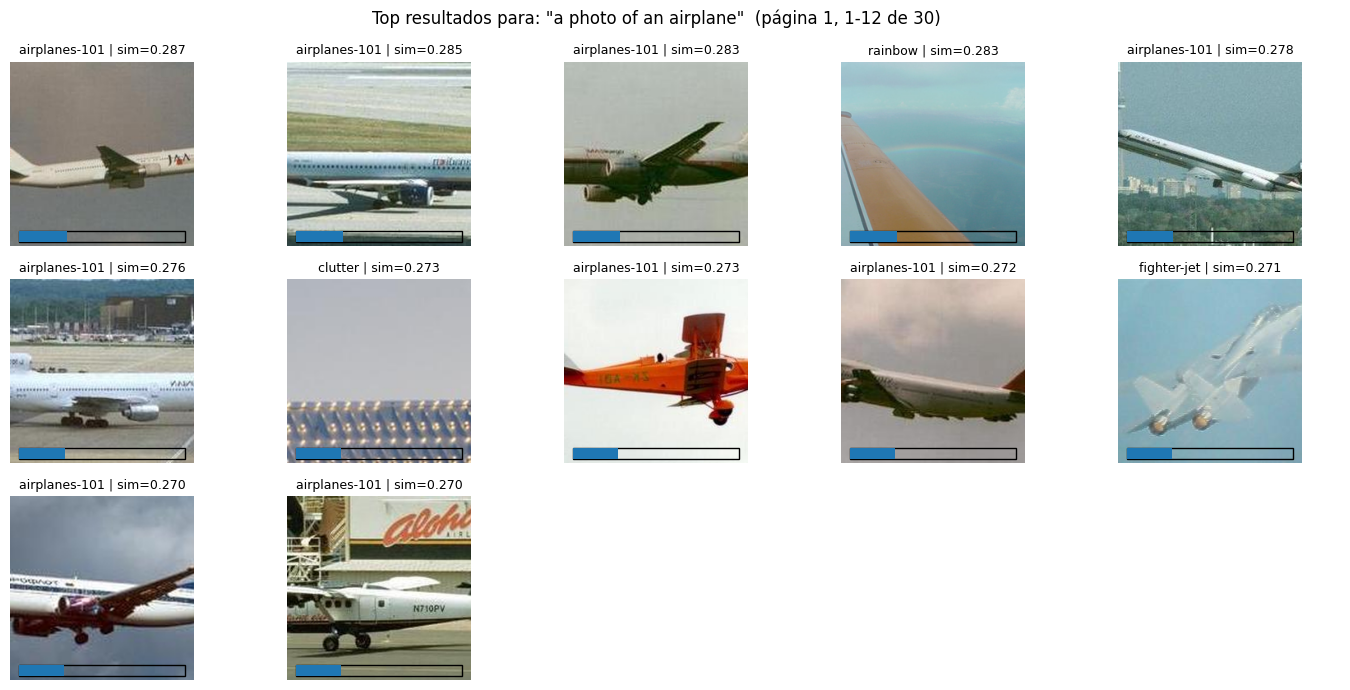

Renderizado en 0.89s


In [16]:
df_air = search_and_visualize("a photo of an airplane", topk=30, per_page=12, page=1)

Consulta: a photo of a raccoon
Embedding: 0.011s | Búsqueda: 0.002s | Resultados: 30


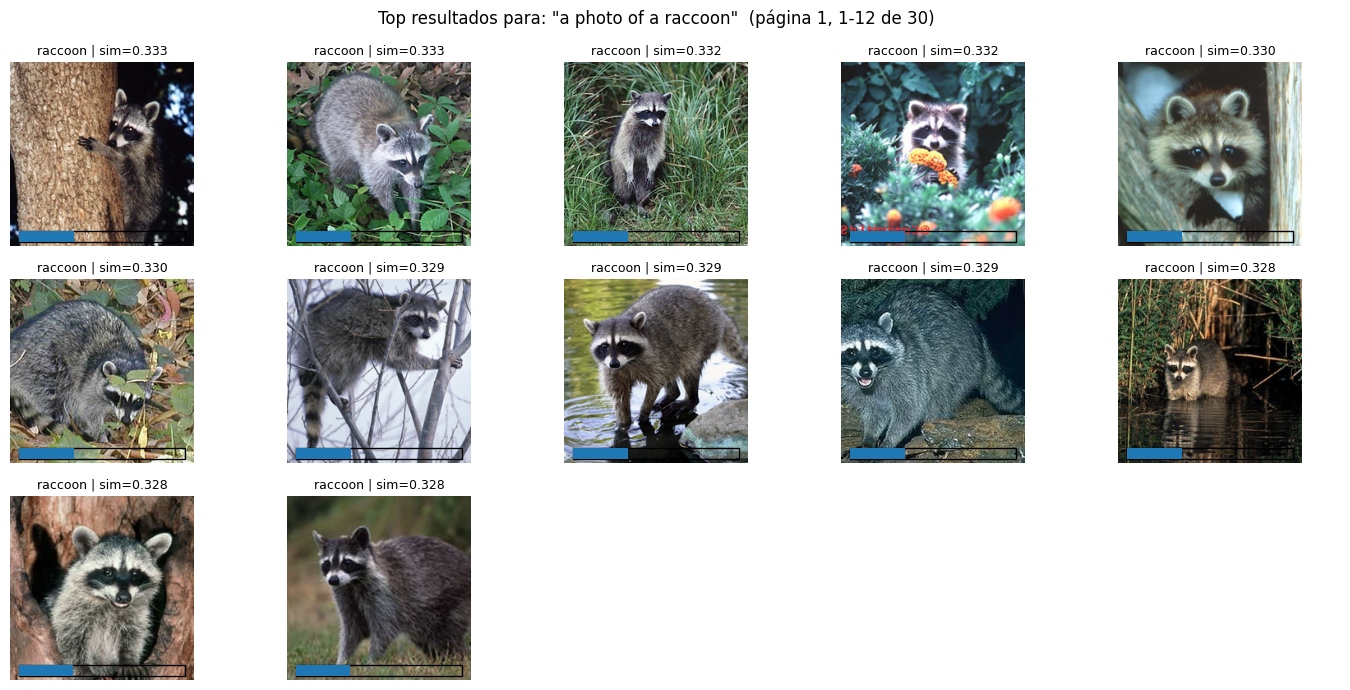

Renderizado en 0.70s


In [23]:
df_raccoon = search_and_visualize("a photo of a raccoon", topk=30, class_filter=["raccoon"], per_page=12)

Consulta: a photo of a guitar
Embedding: 0.012s | Búsqueda: 0.002s | Resultados: 50


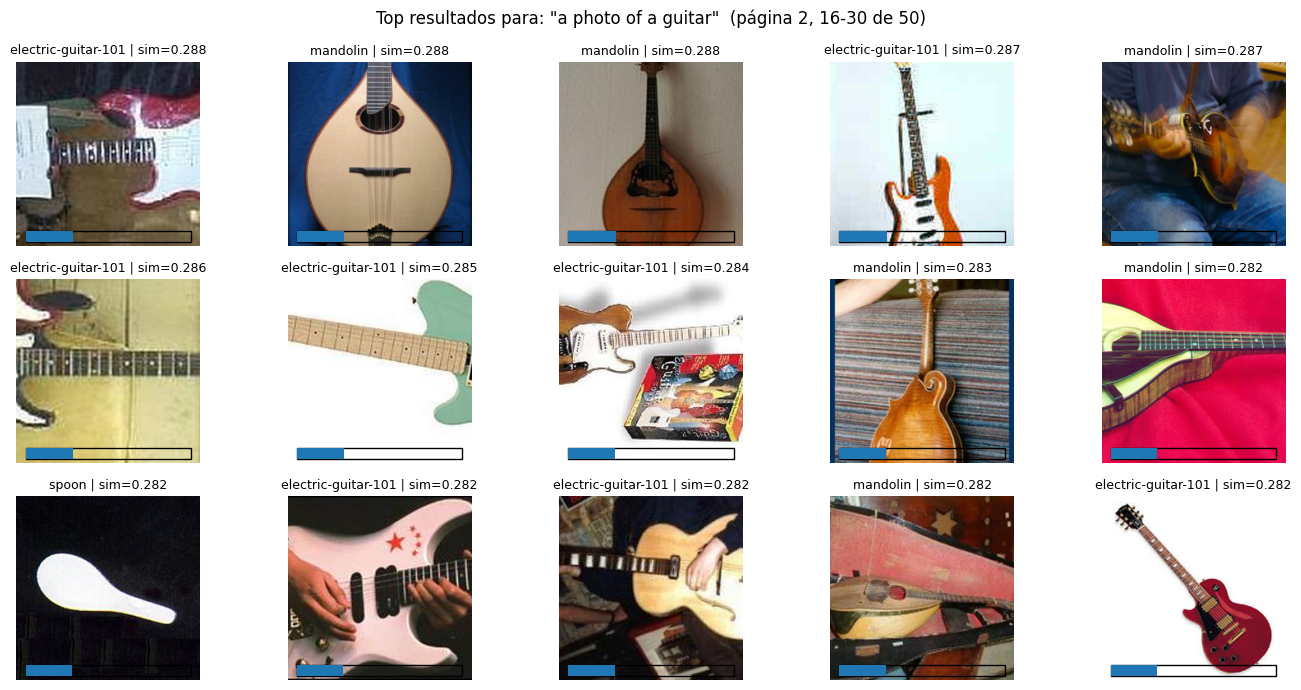

Renderizado en 1.05s


In [22]:
df_guitar = search_and_visualize("a photo of a guitar", topk=50, min_sim=0.20, per_page=15, page=2)